# Preparação da base de dados para treinar os classificadores

In [1]:
from src import (
    Folder,
    GetModel,
    SegmentedList,
    ds2df,
    save_results,
    File2df,
    Best_rf,
    MLP,
    SVM,
    XGBoost,
    KNN,
    GBM,
    List2Best,
    Save_model
    )

from os.path import join
DATA = "Dados"
MODEL = "Models"

In [ ]:
#adquindo as imagens e seus respectivos rotulos
#dataBasePath = join(DATA,"dados")
dataBasePath = join(DATA,"changed","segmentation")
images, labels = Folder(dataBasePath)

## Caso as imagens não estejam segmentadas, podemos segmentalas

In [ ]:

segmentation_model = GetModel(join("models,best.pt"))
process_images = SegmentedList(images,segmentation_model)

In [ ]:
# com as imagens processadas, precisamos descartar as imagens que não foram segmentadas e salvar seu nome em um arquivo com as falhas

def clear_fails(process_images, labels,anotation_fails: str =r"Dados\falhas.txt"):
    fails = []

    # Iterando de trás para frente
    for i in range(len(process_images) - 1, -1, -1):
        if process_images[i] is None:
            fails.append(labels[i])
            
            # Remove os elementos das listas
            del process_images[i]
            del labels[i]


    with open(anotation_fails, "w") as arquivo:
        for fail in fails:
            arquivo.write(fail + "\n")
            
    print("Imagens segmentadas com sucesso: ",len(process_images))
    print("Rotulos validos: ",len(labels))

#clear_fails(process_images,labels)

# Extraindo as Caracteristicas de interesse da base de dados

In [ ]:
#df = ds2df(process_images,labels)
df = ds2df(images,labels)

### Visando evitar repetir o processamento para a mesma base de dados podemos exportar a mesma para um arquivo e apenas ler a partir do arquivo quando quisermos novamente

In [ ]:
# vamos registrar os datasets por dada de sua geração
from datetime import datetime
data = str(datetime.today()).split(" ")[0].split("-")
data = data[2] + '-' + data[1] + '-' + data[0]
data

In [ ]:

save_results(df,DATA,data,".csv")

### Carregando nossos dados a partir de um dataset .csv

In [3]:
# caso não tenhamos nosso DataFrame carregado, podemos carregalo apartir de um arquivo
df = File2df(join(DATA,"13-03-2024.csv"))

df.drop("Unnamed: 0",axis=1,inplace=True)
df.columns

.csv


Index(['Name', 'FAMACHA', 'Mean_R', 'Mean_G', 'Mean_B', 'Median_R', 'Median_G',
       'Median_B', 'Std_R', 'Std_G', 'Std_B'],
      dtype='object')

# Treinando os classificadores

In [ ]:
rf = Best_rf(df,join("docs","classification"))


### Vamos pegar a melhor versão de cada modelo

In [4]:
bests_list = []

funcs = [MLP,SVM,XGBoost,KNN,GBM]
names = ["MLP","SVM","XGBoost","KNN","GBM"]

args = (0.1,0.2,0.3)

for i,func in enumerate(funcs,0):

    for arg in args:
        
        _, accuracy, precision, recall, f1, kappa = func(df,arg)
        bests_list.append((names[i],arg,accuracy, precision, recall, f1, kappa))
    
bests_list

[('MLP', 0.1, 70.69, 68.0, 97.14, 80.0, 31.05),
 ('MLP', 0.2, 70.69, 74.8, 71.32, 73.02, 40.98),
 ('MLP', 0.3, 72.13, 68.58, 92.27, 78.68, 40.85),
 ('SVM', 0.1, 76.72, 78.67, 84.29, 81.38, 50.44),
 ('SVM', 0.2, 74.14, 71.7, 88.37, 79.17, 46.03),
 ('SVM', 0.3, 68.39, 66.41, 87.63, 75.56, 33.16),
 ('XGBoost', 0.1, 98.28, 100.0, 97.14, 98.55, 96.42),
 ('XGBoost', 0.2, 94.83, 95.35, 95.35, 95.35, 89.52),
 ('XGBoost', 0.3, 94.25, 95.79, 93.81, 94.79, 88.38),
 ('KNN', 0.1, 92.24, 95.52, 91.43, 93.43, 83.97),
 ('KNN', 0.2, 85.34, 86.82, 86.82, 86.82, 70.32),
 ('KNN', 0.3, 83.91, 83.17, 89.18, 86.07, 67.08),
 ('GBM', 0.1, 93.1, 95.59, 92.86, 94.2, 85.7),
 ('GBM', 0.2, 87.93, 86.86, 92.25, 89.47, 75.36),
 ('GBM', 0.3, 87.07, 86.34, 91.24, 88.72, 73.6)]

In [3]:
output = join("docs","classification")

In [6]:


best = List2Best(bests_list,output,f"not rf.csv",True)
best

'XGBoost'

In [ ]:
# caso gostemos do resultado e desejemos salvar o modelo
Save_model(model,join(MODEL,'rf'))

# Avaliando o comparativo dos modelos 

In [4]:
# caso não tenhamos nosso DataFrame carregado, podemos carregalo apartir de um arquivo
result_models = File2df(join(output,"not rf.csv"))

#result_models.drop("Unnamed: 0",axis=1,inplace=True)
result_models.columns

.csv


Index(['Modelo', 'Versão', 'Accuracy', 'Precision', 'Recall', 'F1', 'Kappa',
       'Total'],
      dtype='object')

In [10]:
result_models

,Modelo,Versão,Accuracy,Precision,Recall,F1,Kappa,Total
0,XGBoost,0.1,98.28,100.00,97.14,98.55,96.42,490.39
1,XGBoost,0.2,94.83,95.35,95.35,95.35,89.52,470.40
2,XGBoost,0.3,94.25,95.79,93.81,94.79,88.38,467.02
3,GBM,0.1,93.10,95.59,92.86,94.20,85.70,461.45
4,KNN,0.1,92.24,95.52,91.43,93.43,83.97,456.59
5,GBM,0.2,87.93,86.86,92.25,89.47,75.36,431.87
6,GBM,0.3,87.07,86.34,91.24,88.72,73.60,426.97
7,KNN,0.2,85.34,86.82,86.82,86.82,70.32,416.12
8,KNN,0.3,83.91,83.17,89.18,86.07,67.08,409.41
9,SVM,0.1,76.72,78.67,84.29,81.38,50.44,371.50


In [15]:
rotulos = result_models.Modelo.unique()
rotulos

array(['XGBoost', 'GBM', 'KNN', 'SVM', 'MLP'], dtype=object)

In [9]:
# Suponha que 'df' seja o DataFrame contendo os resultados dos modelos

# Rótulos dos modelos
model_labels = ['XGBoost', 'GBM', 'KNN', 'SVM', 'MLP']

# Lista para armazenar os melhores resultados de cada modelo
best_results = []

# Iterar sobre os rótulos dos modelos
for model_label in model_labels:
    # Filtrar o DataFrame para o modelo atual
    model_df = result_models[result_models['Modelo'] == model_label]
    
    # Encontrar a linha com o melhor resultado para o modelo atual
    best_row = model_df.loc[model_df['Total'].idxmax()]
    
    # Adicionar o resultado à lista de melhores resultados
    best_results.append(best_row)

import pandas as pd
# Criar um DataFrame com os melhores resultados
print(best_results)
best_results_df = pd.DataFrame(best_results)

# Exibir o DataFrame com os melhores resultados
print(best_results_df)


[Modelo       XGBoost
Versão           0.1
Accuracy       98.28
Precision      100.0
Recall         97.14
F1             98.55
Kappa          96.42
Total         490.39
Name: 0, dtype: object, Modelo          GBM
Versão          0.1
Accuracy       93.1
Precision     95.59
Recall        92.86
F1             94.2
Kappa          85.7
Total        461.45
Name: 3, dtype: object, Modelo          KNN
Versão          0.1
Accuracy      92.24
Precision     95.52
Recall        91.43
F1            93.43
Kappa         83.97
Total        456.59
Name: 4, dtype: object, Modelo         SVM
Versão         0.1
Accuracy     76.72
Precision    78.67
Recall       84.29
F1           81.38
Kappa        50.44
Total        371.5
Name: 9, dtype: object, Modelo          MLP
Versão          0.3
Accuracy      72.13
Precision     68.58
Recall        92.27
F1            78.68
Kappa         40.85
Total        352.51
Name: 11, dtype: object]
     Modelo  Versão  Accuracy  Precision  Recall     F1  Kappa   Total
0   XGB

In [7]:
import matplotlib.pyplot as plt

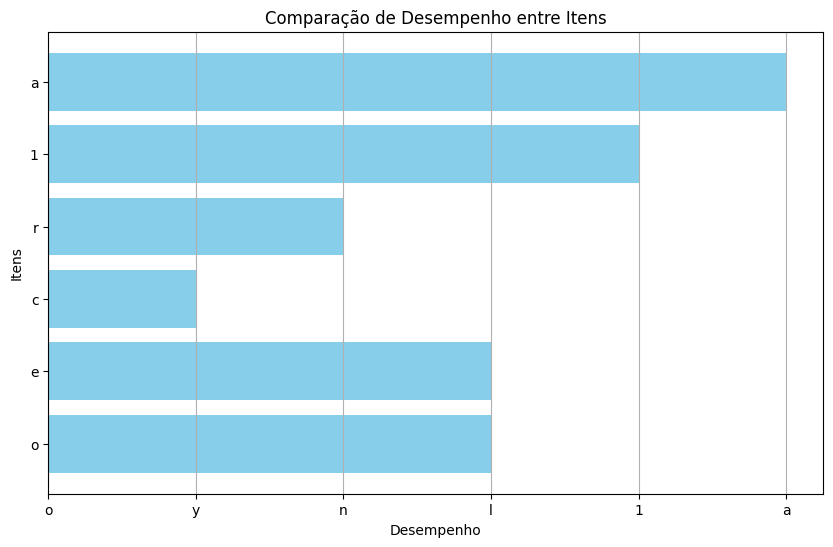

In [8]:
# Extrair os nomes dos itens e os valores de desempenho
itens = [item[1] for item in result_models]
desempenho = [item[-1] for item in result_models]

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.barh(itens, desempenho, color='skyblue')
plt.xlabel('Desempenho')
plt.ylabel('Itens')
plt.title('Comparação de Desempenho entre Itens')
plt.grid(axis='x')
plt.show()